In [1]:
%run ../input/python-recipes/cmap_header.py
%cmap_header Code Modules & Settings

In [2]:
import os,time,datetime
import tensorflow as tf,numpy as np,pylab as pl
from IPython.display import display,HTML,clear_output
import tensorflow.keras.layers as tkl,\
tensorflow.keras.utils as tku

In [3]:
%cmap_header Data Loading

In [4]:
url='https://people.eecs.berkeley.edu/~tinghuiz/projects/'+\
    'pix2pix/datasets/facades.tar.gz'
zip_path=tf.keras.utils.get_file(
    'facades.tar.gz',origin=url,extract=True)
file_path=os.path.join(os.path.dirname(zip_path),'facades/')

30171136/30168306 [==============================] - 8s 0us/step


In [5]:
buffer_size,batch_size,img_size,jitter_size=400,1,256,288
def load_img(file_name):
    img=tf.io.read_file(file_name)
    img=tf.image.decode_jpeg(img)
    w=tf.shape(img)[1]//2
    real_img=tf.cast(img[:,:w,:],tf.float32)
    input_img=tf.cast(img[:,w:,:],tf.float32)
    return input_img,real_img
randi=np.random.randint(100,120,1)
file_name='train/%03d'%randi+'.jpg'

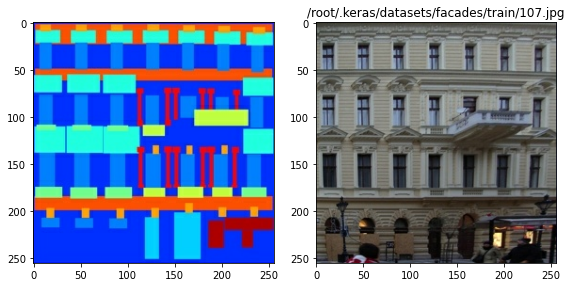

In [6]:
def display_img(file_name):
    input_img,real_img=load_img(file_name)
    fig=pl.figure(figsize=(8,4))
    fig.add_subplot(1,2,1); pl.imshow(input_img/255.)
    fig.add_subplot(1,2,2); pl.imshow(real_img/255.)
    pl.title(file_name); pl.tight_layout(); pl.show()
display_img(file_path+file_name)

In [7]:
%cmap_header Image Processing

In [8]:
def nnresize_img(input_img,real_img,height,width):
    input_img=tf.image.resize(
        input_img,[height,width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_img=tf.image.resize(
        real_img,[height,width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_img,real_img
def randomcrop_img(input_img,real_img,
                   height=img_size,width=img_size):
    stacked_img=tf.stack([input_img,real_img],axis=0)
    cropped_img=tf.image.random_crop(
        stacked_img,size=[2,height,width,3])
    return cropped_img[0],cropped_img[1]
def normalize_img(input_img,real_img):
    return (input_img/127.5)-1,(real_img/127.5)-1
@tf.function()
def randomjitter_img(input_img,real_img,
                     img_size=img_size,jitter_size=jitter_size):
    input_img,real_img=nnresize_img(
        input_img,real_img,jitter_size,jitter_size)
    input_img,real_img=randomcrop_img(
        input_img,real_img,height=img_size,width=img_size)
    if tf.random.uniform(())>.5:
        input_img=tf.image.flip_left_right(input_img)
        real_img=tf.image.flip_left_right(real_img)
    return input_img,real_img

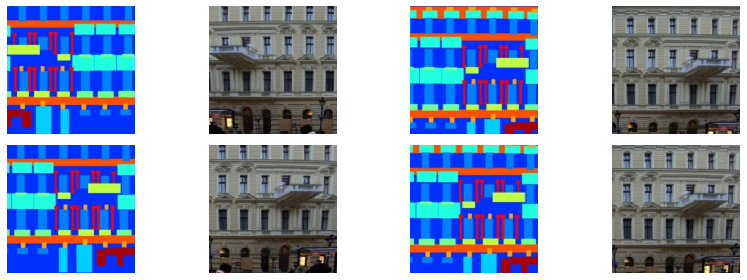

In [9]:
def display_rj_img(file_name,img_size=img_size,
                   jitter_size=jitter_size):
    input_img,real_img=load_img(file_name)
    pl.figure(figsize=(12,4))
    for i in range(4):
        rj_input_img,rj_real_img=randomjitter_img(
            input_img,real_img,img_size,jitter_size)
        pl.subplot(2,4,2*i+1); pl.axis('off')
        pl.imshow(rj_input_img/255.)
        pl.subplot(2,4,2*i+2); pl.axis('off')
        pl.imshow(rj_real_img/255.)
    pl.tight_layout(); pl.show()
display_rj_img(file_path+file_name)

In [10]:
%cmap_header TF Datasets

In [11]:
def preprocess_train(file_name,img_size=img_size,
                     jitter_size=jitter_size):
    input_img,real_img=load_img(file_name)
    input_img,real_img=randomjitter_img(
        input_img,real_img,img_size,jitter_size)
    input_img,real_img=normalize_img(input_img,real_img)
    return input_img,real_img
def preprocess_test(file_name,img_size=img_size):
    input_img,real_img=load_img(file_name)
    input_img,real_img=nnresize_img(
        input_img,real_img,height=img_size,width=img_size)
    input_img,real_img=normalize_img(input_img,real_img)
    return input_img,real_img

In [12]:
train_ds=tf.data.Dataset.list_files(file_path+'train/*.jpg')
train_ds=train_ds.map(
    preprocess_train,num_parallel_calls=tf.data.AUTOTUNE)
train_ds=train_ds.shuffle(buffer_size).batch(batch_size)
test_ds=tf.data.Dataset.list_files(file_path+'test/*.jpg')
test_ds=test_ds.map(preprocess_test)
test_ds=test_ds.batch(batch_size)

In [13]:
%cmap_header Generator Building

In [14]:
channels,filters,size,gen_lambda=3,3,4,100
input_img,real_img=load_img(file_path+file_name)
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
%cmap_header encoder => (Conv->Batchnorm->Leaky ReLU)|22|Aladin

In [16]:
def downsample(filters,size,apply_batchnorm=True):
    initializer=tf.random_normal_initializer(0.,.02)
    result=tf.keras.Sequential()
    result.add(tkl.Conv2D(
        filters,size,strides=2,padding='same',
        kernel_initializer=initializer,use_bias=False))
    if apply_batchnorm:
        result.add(tkl.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result
downsample_model=downsample(filters,size)
downsample_result=downsample_model(
    tf.expand_dims(input_img,0))
downsample_result.shape

TensorShape([1, 128, 128, 3])

In [17]:
%cmap_header decoder => \
(Transposed Conv->Batchnorm->Dropout(the first 3 blocks)->ReLU)|22|Aladin

In [18]:
def upsample(filters,size,apply_dropout=False,dropout=.5):
    initializer=tf.random_normal_initializer(0.,.02)
    result=tf.keras.Sequential()
    result.add(tkl.Conv2DTranspose(
        filters,size,strides=2,padding='same',
        kernel_initializer=initializer,use_bias=False))
    result.add(tkl.BatchNormalization())
    if apply_dropout:
       result.add(tf.keras.layers.Dropout(dropout))
    result.add(tkl.ReLU())
    return result
upsample_model=upsample(filters,size)
upsample_result=upsample_model(downsample_result)
upsample_result.shape

TensorShape([1, 256, 256, 3])

In [19]:
%cmap_header skip connections: encoder<=>decoder (U-Net like)|22|Aladin

In [20]:
def Generator(img_size=img_size,channels=channels):
    inputs=tkl.Input(shape=[img_size,img_size,channels])
    downsample_stack=[
        downsample(64,4,apply_batchnorm=False),
        downsample(192,4),downsample(256,4), 
        downsample(512,4),downsample(1024,4),
        downsample(1024,4),downsample(1024,4),
        downsample(1024,4),]
    upsample_stack=[
        upsample(1024,4,apply_dropout=True),
        upsample(1024,4,apply_dropout=True),
        upsample(1024,4,apply_dropout=True),
        upsample(512,4),upsample(256,4),
        upsample(192,4),upsample(64,4),]
    initializer=tf.random_normal_initializer(0.,.02)
    last=tkl.Conv2DTranspose(
        channels,4,strides=2,padding='same',
        kernel_initializer=initializer,activation='tanh')
    x=inputs; skips=[]
    for ds in downsample_stack:
        x=ds(x); skips.append(x)
    skips=reversed(skips[:-1])
    for us,skip in zip(upsample_stack,skips):
        x=us(x); x=tkl.Concatenate()([x,skip])
    outputs=last(x)
    return tf.keras.Model(inputs=inputs,outputs=outputs)

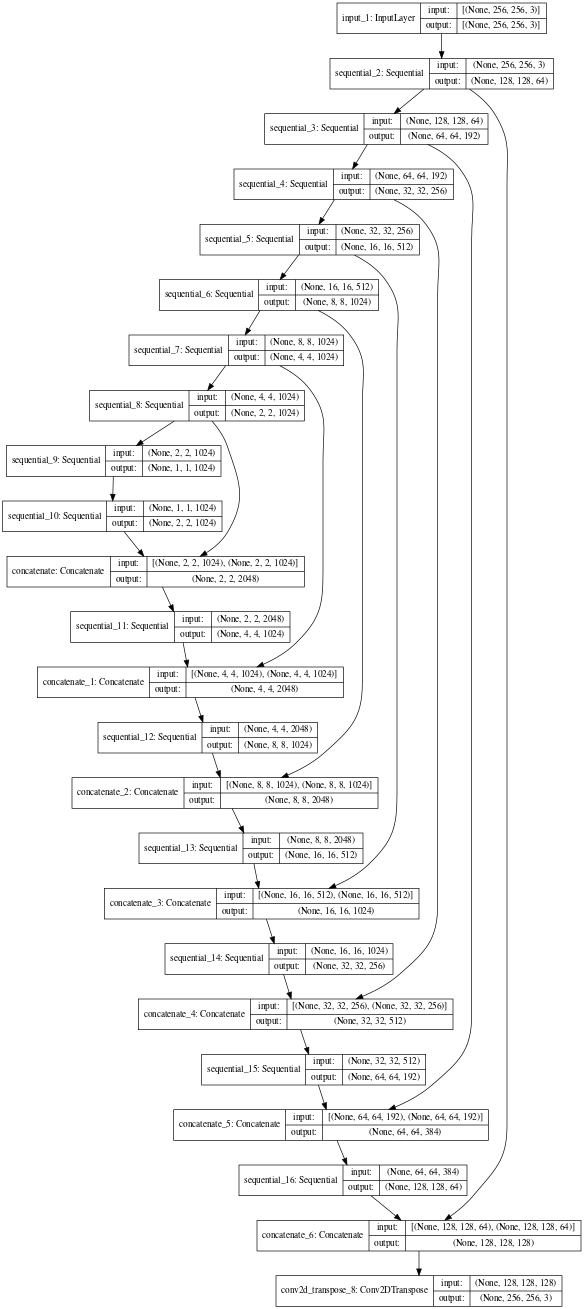

In [21]:
generator=Generator()
tku.plot_model(generator,show_shapes=True,dpi=48)

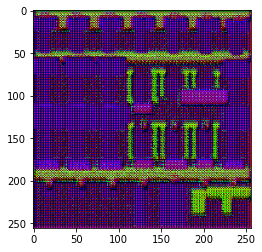

In [22]:
gen_output_img=generator(
    input_img[tf.newaxis,...],training=False)
pl.imshow(np.clip(gen_output_img[0,...],0,1));

In [23]:
def generator_loss(disc_generated_output,gen_output,target_img):
    gan_loss=loss_object(
        tf.ones_like(disc_generated_output),disc_generated_output)
    l1_loss=tf.reduce_mean(tf.abs(target_img-gen_output))
    total_gen_loss=gan_loss+(gen_lambda*l1_loss)
    return total_gen_loss,gan_loss,l1_loss

In [24]:
%cmap_header Discriminator Building

In [25]:
%cmap_header PatchGAN: \
discriminator => (Conv->BatchNorm->Leaky ReLU)|24|Aladin

In [26]:
def Discriminator(img_size=img_size,channels=channels):
    initializer=tf.random_normal_initializer(0.,.02)
    inp=tkl.Input(shape=[img_size,img_size,channels],
                  name='input_img')
    tar=tkl.Input(shape=[img_size,img_size,channels],
                  name='target_img')
    x=tkl.concatenate([inp,tar])
    ds1=downsample(64,4,False)(x)
    ds2=downsample(192,4)(ds1)
    ds3=downsample(256,4)(ds2)
    zero_pad1=tkl.ZeroPadding2D()(ds3)
    conv=tkl.Conv2D(
        512,4,strides=1,kernel_initializer=initializer,
        use_bias=False)(zero_pad1)
    batchnorm1=tkl.BatchNormalization()(conv)
    leaky_relu=tkl.LeakyReLU()(batchnorm1)
    zero_pad2=tkl.ZeroPadding2D()(leaky_relu)
    last=tkl.Conv2D(
        1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp,tar],outputs=last)

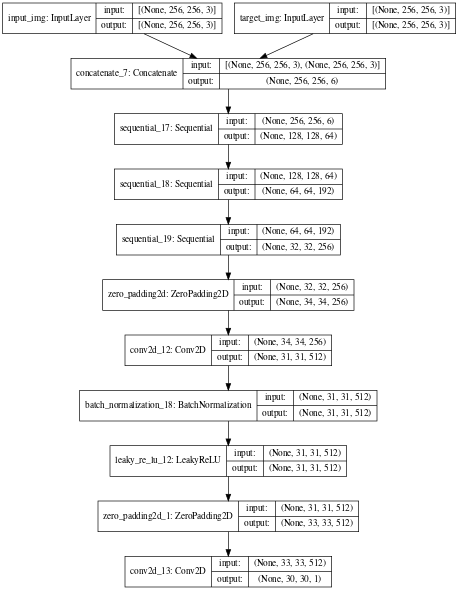

In [27]:
discriminator=Discriminator()
tku.plot_model(discriminator,show_shapes=True,dpi=48)

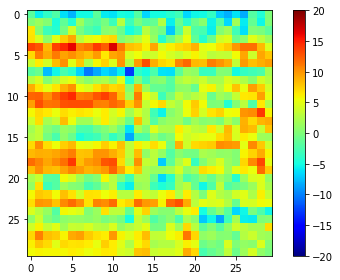

In [28]:
disc_output_img=discriminator(
    [input_img[tf.newaxis,...],gen_output_img],training=False)
pl.imshow(disc_output_img[0,...,-1],vmin=-20,vmax=20,cmap='jet')
pl.colorbar(); pl.tight_layout();

In [29]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss=loss_object(
        tf.ones_like(disc_real_output),disc_real_output)
    generated_loss=loss_object(
        tf.zeros_like(disc_generated_output),disc_generated_output)
    total_disc_loss=real_loss+generated_loss
    return total_disc_loss

In [30]:
%cmap_header Model Optimizers, Callbacks & Visualizations

In [31]:
generator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=.5)
discriminator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=.5)

In [32]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,discriminator=discriminator)

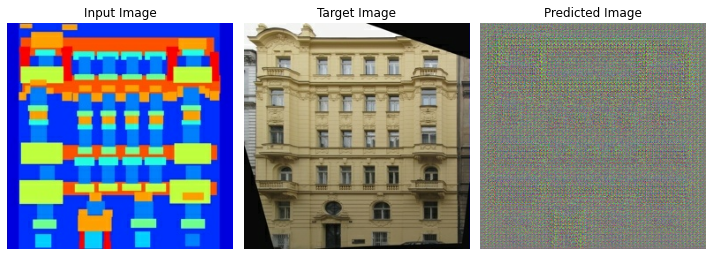

In [33]:
def generated_images(model,test_input_img,test_target_img):
    predicted_img=model(test_input_img,training=True)
    pl.figure(figsize=(10,10))
    display_list=[test_input_img[0],test_target_img[0],predicted_img[0]]
    title=['Input Image','Target Image','Predicted Image']
    for i in range(3):
        pl.subplot(1,3,i+1)
        pl.imshow(display_list[i]*.5+.5)
        pl.axis('off'); pl.title(title[i])
    pl.tight_layout(); pl.show()
for test_input_img,test_target_img in test_ds.take(1):
    generated_images(generator,test_input_img,test_target_img)

In [34]:
%cmap_header Model Training

In [35]:
epochs=150; log_dir='logs/'
summary_writer=tf.summary.create_file_writer(
    log_dir+'fit/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [36]:
@tf.function
def train_step(input_img,target_img,epoch):
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        gen_output=generator(input_img,training=True)
        disc_real_output=discriminator([input_img,target_img],training=True)
        disc_generated_output=discriminator([input_img,gen_output],training=True)
        gen_total_loss,gen_gan_loss,gen_l1_loss=\
        generator_loss(disc_generated_output,gen_output,target_img)
        disc_loss=discriminator_loss(disc_real_output,disc_generated_output)
    generator_gradients=gen_tape.gradient(
        gen_total_loss,generator.trainable_variables)
    discriminator_gradients=disc_tape.gradient(
        disc_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(
        generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        discriminator_gradients,discriminator.trainable_variables))
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',gen_total_loss,step=epoch)
        tf.summary.scalar('gen_gan_loss',gen_gan_loss,step=epoch)
        tf.summary.scalar('gen_l1_loss',gen_l1_loss,step=epoch)
        tf.summary.scalar('disc_loss',disc_loss,step=epoch)

In [37]:
def fit(train_ds,epochs,test_ds):
    for epoch in range(epochs):
        start=time.time()
        clear_output(wait=True)
        for test_input_img,test_target_img in test_ds.take(1):
            generated_images(generator,test_input_img,test_target_img)
        print('epoch: ',epoch)
        for n,(input_img,target_img) in train_ds.enumerate():
            print('.',end='')
            if (n+1)%100==0: print()
            train_step(input_img,target_img,epoch)
        if (epoch+1)%20==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print ('time for epoch {} => {} sec\n'.format(
            epoch+1,time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)

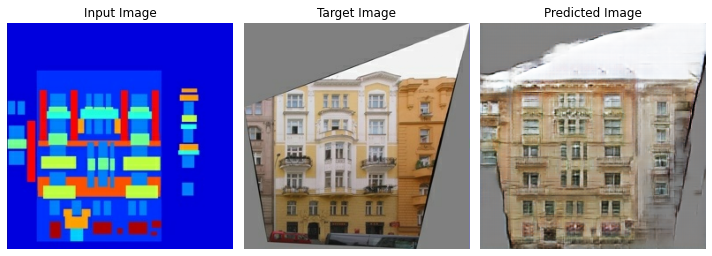

epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
time for epoch 150 => 54.79965305328369 sec



In [38]:
fit(train_ds,epochs,test_ds)

In [39]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir));

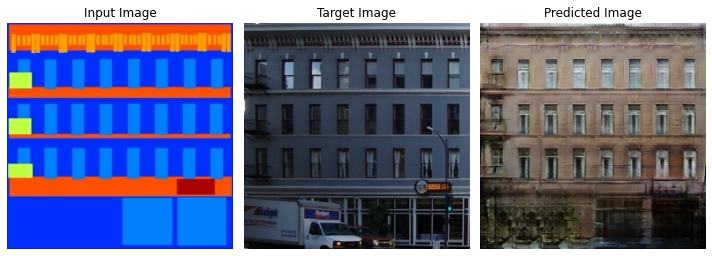

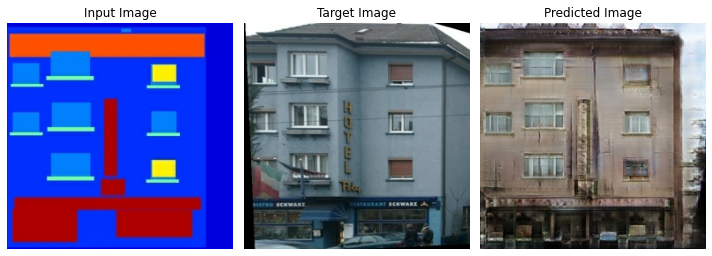

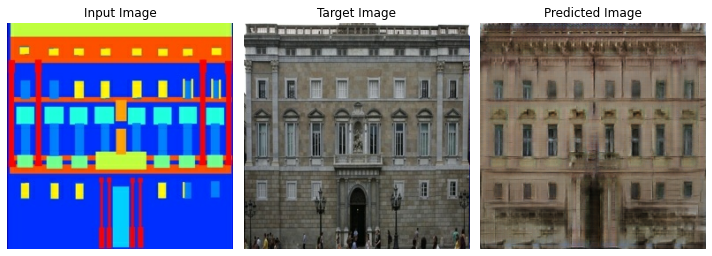

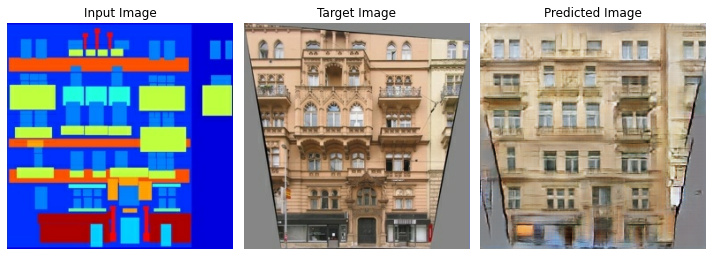

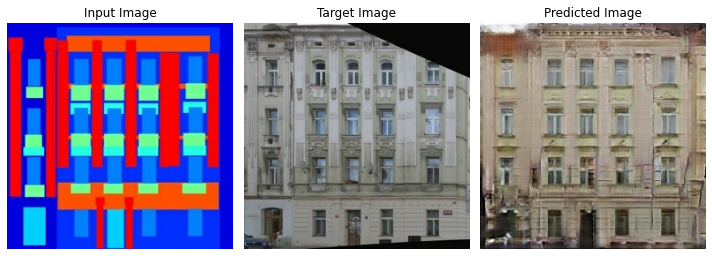

In [41]:
for test_input_img,test_target_img in test_ds.take(5):
    generated_images(generator,test_input_img,test_target_img)